# 世界モデル道場(生成モデル編)

**VAE, VQ-VAE, Diffusionの理論と実装, 比較**

## 共通部分の定義（ライブラリ, データ, GPU）

In [1]:
%matplotlib inline
import glob, os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from typing import Tuple

rng = np.random.RandomState(1234)
random_state = 42

In [15]:
#----CUDA -> MPS(Mac) -> CPU の順で自動選択
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # Apple Silicon (M1/M2) 向け
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [2]:
#----画像の前処理設定-----
#CelebAのデータセットは、[3, 218, 178]なので、128*128に変更
transform = transforms.Compose([
    transforms.CenterCrop(178),         # まず正方形(178x178)にセンタークロップ
    transforms.Resize(128),              # 128*128へ縮小
    transforms.ToTensor(),              # [0,1]
])

#----カスタムDatasetの定義----
class CelebAImages(Dataset):
    def __init__(self, root, transform=None):
        # jpgが直下に並んでいる前提
        self.paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        assert len(self.paths) > 0, f'No jpg found in: {root}'
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, 0   # ラベルは使わないのでダミー

#----データのパス----
root_dir = '/Users/wadarei/genai-playground/00_data/img_align_celeba/img_align_celeba'
dataset = CelebAImages(root_dir, transform)

#----8:2 で分割----
n = len(dataset); n_train = int(n*0.8)
train_data, val_data = torch.utils.data.random_split(dataset, [n_train, n-n_train],
                                                     generator=torch.Generator().manual_seed(42))
#----DataLoader化----
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=4)

In [3]:
#----データの確認----
# train_loaderから1バッチ取得
images, _ = next(iter(train_loader))


# 画像を表示
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    if i < images.shape[0]:
        # 画像データを可視化用に整形
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.axis('off')

plt.tight_layout()
plt.show()
print("Train:", len(train_data))
print("Valid:", len(val_data))
print(images.shape)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=77, pipe_handle=91)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'CelebAImages' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

## VAE(Variational Auto Encoder)

In [ ]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    """ torch.log(0)によるnanを防ぐ目的 """
    return torch.log(torch.clamp(x, min=1e-10))

class VAE(nn.Module):
    """VAEモデルの実装"""
    def __init__(self, z_dim:int) -> None:
        """
        Parameters
        z_dim : int
          潜在空間の次元数
        """
        super().__init__()

        #Encoder:  xを入力として、ガウス分布のパラメータmu, sigmaを出力
        #入力画像：[B, 3, 128, 128]
        self.conv_enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # -> [B, 64, 64, 64]
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), # -> [B, 128, 32, 32]
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # -> [B, 256, 16, 16]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1), # -> [B, 512, 8, 8]
            nn.ReLU(inplace=True),
        )
        """
        #厳密には定義しなくていいけど、その後のmu, sigmaのlinearで定義するために必要
        """
        self.enc_flat = 512*8*8
        self.enc_mu = nn.Linear(self.enc_flat, z_dim)
        self.enc_var = nn.Linear(self.enc_flat, z_dim)

        #Decoder: zを入力として、ガウス分布のパラメータmu, sigmaを出力
        self.fc_dec = nn.Linear(z_dim, self.enc_flat)
        self.conv_dec = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # -> [B, 256, 16, 16]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # -> [B, 128, 32, 32]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64,  4, 2, 1),  # -> [B, 64, 64, 64]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64,  3,   4, 2, 1),  # -> [B, 3, 128, 128]
            nn.Sigmoid()  # 出力を [0,1] に収める
        )

    def _encoder(self, x: torch.Tensor):
      """
      エンコーダは、xから平均と分散を出力するところ！！
      -------------
      Parameters
      x: torch.Tensor(b, c, h, w)
      """
      x = self.conv_enc(x)
      x = torch.flatten(x, start_dim=1) #バッチだけ残すので、start_dim=1
      mean = self.enc_mu(x) #平均
      log_var = self.enc_var(x) #対数分散
      return mean, log_var

    def _sample_z(self, mean: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
      """
      VAEでは「潜在変数 𝑧」を確率的にサンプリングする.
      しかし、確率的なサンプリングでは微分が不可能になる.
      そのため、再パラメータ化トリックが必要！！
      -------------------
      Parameters
      mean: torch.Tensor(b, z_dim)
        エンコーダが出力するガウス分布の平均
      log_var: torch.Tensor(b, z_dim)
        エンコーダが出力するガウス分布の対数分散
      """
      std = torch.exp(0.5 * log_var) #標準偏差
      eps = torch.randn_like(std) #stdと同じ形の乱数を生成！(平均0, 分散1)
      z = mean + std * eps
      return z

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        """
        VAEのデコーダ部分:zを受け取り、xを再構成する
        ----------
        Parameters
        z: torch.Tensor(b, z_dim)
          潜在変数
        ----------
        returns
        x : torch.Tensor(b, c, h, w)
        """
        x = self.fc_dec(z)
        # x.viewはreshapeと同じ働き
        x = x.view(-1, 512, 8, 8)  #-1は、PyTorchに「この次元は自分で計算して」と伝える特別な値。
        x = self.conv_dec(x)
        return x

    def forward(self, x: torch.Tensor):
        """
        順伝播
        ---------
        Parameters
        x : torch.Tensor ( b, c, h, w )
              入力画像．
        ---------
        Returns
        x : torch.Tensor ( b, c, h, w )
              再構成画像．
        z : torch.Tensor ( b, z_dim )
              潜在変数．
        """
        mean, log_var = self._encoder(x)
        z = self._sample_z(mean, log_var)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor):
        """
        目的関数の計算
        ----------
        parameters
        x: torch.Tensor(b, c, h, w)
          入力画像
        ----------
        returns
        reconstruction: torch.Tensor(b, c, h, w)
          再構成画像
        KL: Torch.Tensor(, )
          正則化, エンコーダ（ガウス分布）と事前分布（標準ガウス分布）のKLダイバージェンス．
        """
        mean, log_var = self._encoder(x)
        z = self._sample_z(mean, log_var)
        x_hat = self._decoder(z)

        #-----KLのダイバージェンス, mean, std: (B, z_dim)
        #torch.meanはbatch_sizeに関するもの
        KL = -0.5 * torch.mean(torch.sum(1 + log_var - mean**2 - torch.exp(log_var), dim=1))

        #----再構成誤差(MSE): カラー画像の場合は、バイナリクロスエントロピーではなく平均二乗誤差
        reconstruction = F.mse_loss(x_hat, x, reduction='mean') #ピクセルごとの誤差を平均している #負の対数尤度ではない(平均二乗誤差だから)

        #----目的関数
        loss = reconstruction + KL

        return loss, reconstruction, KL

## 学習

Epoch [1/5]: 100%|███████████| 5065/5065 [42:45<00:00,  1.97it/s, Loss=0.076, Recon=0.075, KL=0.001]


Epoch 1: Loss=0.0891, Recon=0.0768, KL=0.0123


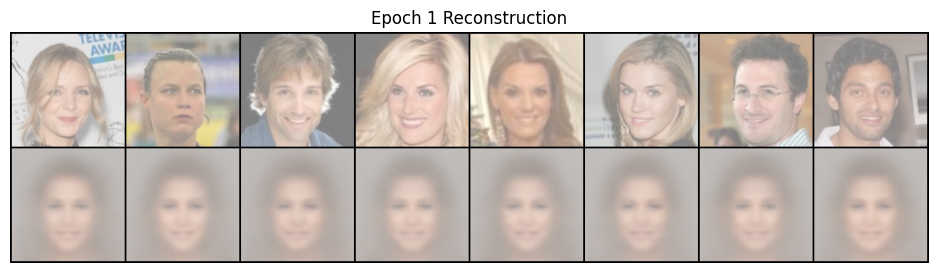

Epoch [2/5]: 100%|███████████| 5065/5065 [42:05<00:00,  2.01it/s, Loss=0.079, Recon=0.078, KL=0.000]


Epoch 2: Loss=0.0764, Recon=0.0762, KL=0.0002


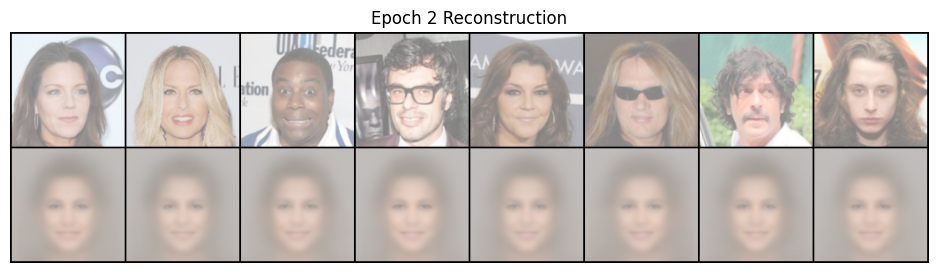

Epoch [3/5]: 100%|███████████| 5065/5065 [41:57<00:00,  2.01it/s, Loss=0.079, Recon=0.079, KL=0.000]


Epoch 3: Loss=0.0762, Recon=0.0761, KL=0.0001


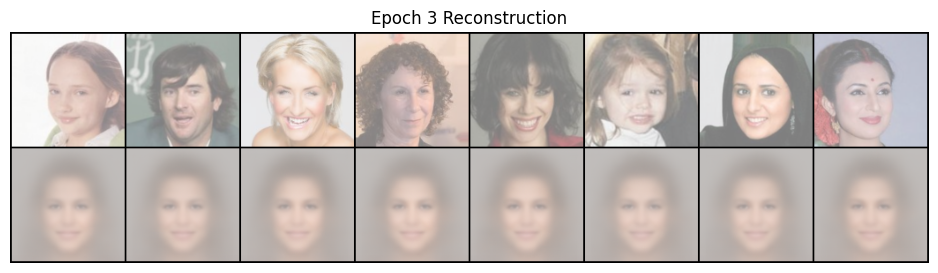

Epoch [4/5]: 100%|███████████| 5065/5065 [40:32<00:00,  2.08it/s, Loss=0.087, Recon=0.087, KL=0.000]


Epoch 4: Loss=0.0761, Recon=0.0761, KL=0.0001


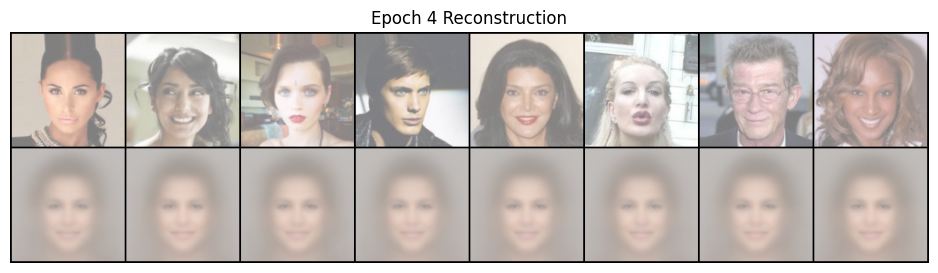

Epoch [5/5]: 100%|███████████| 5065/5065 [40:25<00:00,  2.09it/s, Loss=0.082, Recon=0.082, KL=0.000]


Epoch 5: Loss=0.0761, Recon=0.0760, KL=0.0000


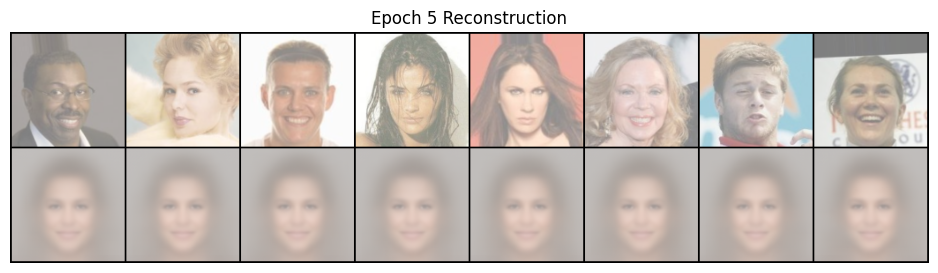

✅ モデル保存完了: vae_celeba.pth


In [11]:
# ---- モデルとオプティマイザ ----
z_dim = 100
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # ← parameters() のスペル修正

# ---- Trainer ----
n_epochs = 5
model.train()

for epoch in range(1, n_epochs + 1):
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch}/{n_epochs}]", ncols=100)
    total_loss, total_recon, total_kl = 0.0, 0.0, 0.0

    for x, _ in pbar:
        x = x.to(device)

        # ---- Forward ----
        loss, recon, kl = model.loss(x)

        # ---- Backprop ----
        optimizer.zero_grad()
        loss.backward()           # backward
        optimizer.step()           #optimizer

        # ---- ロス集計 ----
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

        # ---- 進捗バー更新 ----
        pbar.set_postfix({
            "Loss": f"{loss.item():.3f}",
            "Recon": f"{recon.item():.3f}",
            "KL": f"{kl.item():.3f}"
        })

    # ---- エポックごとの平均 ----
    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)

    print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Recon={avg_recon:.4f}, KL={avg_kl:.4f}")

    # ---- 各エポック後の再構成画像を可視化 ----
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(train_loader))
        x = x.to(device)
        x_hat, _ = model(x)

        def denorm(t): return (t.clamp(0, 1) + 1) / 2  
        comparison = torch.cat([denorm(x[:8]), denorm(x_hat[:8])])
        grid = torchvision.utils.make_grid(comparison, nrow=8)
        plt.figure(figsize=(12, 3))
        plt.axis("off")
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Epoch {epoch} Reconstruction")
        plt.show()

    model.train()  # 次エポックに戻す

# ---- 学習後に保存 ----
torch.save(model.state_dict(), "vae_celeba.pth")
print("✅ モデル保存完了: vae_celeba.pth")